In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import cmath
from scipy.optimize import fsolve, minimize_scalar, minimize, brentq, curve_fit
import matplotlib.pyplot as plt
from matplotlib import cm

class SimpleNamespace(object):
    """A simple container for parameters."""
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
fparams = {'axes.labelsize': 18,
           'axes.titlesize': 18,
           'font.size': 18,
           'legend.fontsize': 16,
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 16,
           'ytick.labelsize': 16,
           'text.usetex': True,
           'image.cmap': 'seismic', 
           'figure.autolayout': True}
plt.rcParams.update(fparams)

# Pauli matrices
sx = np.array([[0, 1], [1, 0]], complex)
sy = np.array([[0 , -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]], complex)
s0 = np.array([[1, 0], [0, 1]], complex)

# Physical constants
MU_B = 5.788381 * 1e-2 # Bohr magneton in units of µeV * mT^(-1).
GAP = 151.8 # This is the gap from the zero-field data, in µeV.
TAU = 0.56 # This is the transmission from the zero-field data

# 8x8 Identity matrix
eye = np.eye(8, dtype=complex)

np.seterr(all='raise', divide=None, over=None, under=None, invalid=None)

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
def pole(x, y, n=0):
    if n==0:
        pol = -1j * np.sqrt(1 - x**2)
    elif n==1:
        pol = -1j * np.sqrt((1 - y)**2 - x**2)
    elif n==2:
        pol = -1j * np.sqrt((1 + y)**2 - x**2)
    else:
        print "Invalid choice for the pole number"
        pol = None
    return pol

In [3]:
pole(0.2, 0.5, 2)

-1.4866068747318506j

In [4]:
def a(x, y):
    a = x * (1 - x**2 + y**2) * np.kron(s0, s0)
    a += y * (-1 - x**2 + y**2) * np.kron(s0, sx) 
    a -= 2 * x * y * np.kron(sx, sx)
    a += (1 - x**2 - y**2) * np.kron(sx, s0)
    return a


def c(x, y):
    return x * np.kron(s0, s0) + y * np.kron(s0, sx) + np.kron(sx, s0);


def g1(x, q0):
    num = q0 * np.kron(sz, sz) + x * np.kron(s0, s0) + np.kron(sx, s0)
    denom = 2 * q0
    return - num / denom


def g2(x, y, q1, q2):
    num = a(x, y) - q1 * q2 * c(x, y) - np.kron(sz, sz) * q1 * q2 * (q1 + q2)
    denom = 2 * q1 * q2 * (q1 + q2)
    return num / denom


def g(x, y, q0, q1, q2):
    return 0.5 * np.kron(g1(x, q0), s0 + sz) + 0.5 * np.kron(g2(x, y, q1, q2), s0 - sz) 


def T(tau):
    r = np.sqrt(1 - tau) / np.sqrt(tau)
    T = eye - 1j * r * np.kron(s0, np.kron(sz, s0))
    T += r * np.kron(s0, np.kron(sy, sx))
    return T

In [16]:
def bound_state_determinant(x, y, tau, phi=np.pi, remove_asymptote=True, tol=1e-6, warn=False):
    q0 = pole(x, y, n=0)
    q1 = pole(x, y, n=1)
    q2 = pole(x, y, n=2)
    phiexp = np.cos(0.5 * phi) * eye - 1j *  np.sin(0.5 * phi) * np.kron(sz, np.kron(s0, s0))
    tfactor = np.dot(phiexp, T(tau)) - eye
    gfactor = np.dot(g(x, y, q0, q1, q2), np.kron(sz, np.kron(sz, s0)))
    m = eye - np.dot(gfactor, tfactor)
    mdet = np.linalg.det(m)
    if remove_asymptote:
        mdet *= (q0 * q1 * q2 * (q1+q2))**8
    if warn and (mdet.imag > tol):
        print "Imaginary part large at:", x, np.abs(x - gap(p)), mdet.imag, mdet.real, mdet.imag/mdet.real
        print Warning("The imaginary part of the determinant is greater than %s" % tol)
    return mdet.real


def func(xs, y, tau, phi=np.pi, remove_asymptote=False):
    domain = lambda x : ((x >= 0) & (x <= 1 - y))
    if isinstance(xs, np.ndarray):
        vals = np.array([bound_state_determinant(x, y, tau, phi, remove_asymptote) if domain(x) else 100 * abs(x) + 100 for x in xs])
        return vals
    else:
        return bound_state_determinant(xs, y, tau, phi)

In [30]:
def find_abs_energies(p):
    
    # Take care of y=0 case
    if p.y == 0:
            Ea = np.sqrt(1 - p.tau * np.sign(p.phi/2)**2)
            return (Ea, Ea)
    
    gap = 1 - p.y
    xs = np.linspace(0., gap, 1000, endpoint=False)
    sample = func(xs, p.y, p.tau, p.phi)
    sign_changes = np.nonzero(np.diff(np.sign(sample)))[0]
    intervals = [[xs[s - 1], xs[s + 1]] for s in sign_changes]
    Ns = len(sign_changes)
    
    # Discard sign changes in consecutive values of the sample
    # These are assumed to be fluctuations
    if Ns == 2 and np.diff(sign_changes)[0]==1:
        print "Discarding sign change detections: too close to each other."
        Ns = 0
    
    # Adjust the boundary conditions in case solutions
    # are very close to x=0 or x=gap
    if Ns:
        for s in sign_changes:
            if s == 0:
                print "first sign change very close to x=0"
                intervals[0][0] = 0.
            #if s == (len(xs)-2):
            #    print "second sign change very close to the gap x=0"
            #    print Ns
            #    intervals[1][1] = gap

    if Ns == 0:
        print "No sign changes:", Ns
        return(gap, gap)
    elif Ns == 1:
        x_1, x_2 = intervals[0]
        try:
            sol1 = brentq(lambda x: func(x, p.y, p.tau, p.phi), x_1, x_2, full_output=False)
        except Exception, e:
            print "Parameters: ", p.y, p.tau, p.phi
            print "Bracketing interval: ", (x_1, x_2)
            print "Function values:", func(x_1, p.y, p.tau, p.phi), func(x_2, p.y, p.tau, p.phi)
            plt.plot(xs, func(xs, p.y, p.tau, p.phi))
            raise e
        return (sol1, gap)
    elif Ns == 2:
        x_1, x_2 = intervals[0]
        x_3, x_4 = intervals[1]
        try:
            sol1 = brentq(lambda x: func(x, p.y, p.tau, p.phi), x_1, x_2, full_output=False)
            sol2 = brentq(lambda x: func(x, p.y, p.tau, p.phi), x_3, x_4, full_output=False)
        except Exception, e:
            print "Parameters:", p.y, p.tau, p.phi
            print "Bracketing interval 1:", (x_1, x_2)
            print "Function values:", func(x_1, p.y, p.tau, p.phi), func(x_2, p.y, p.tau, p.phi)
            print "Bracketing interval 2:", (x_3, x_4)
            print "Function values:", func(x_3, p.y, p.tau, p.phi), func(x_4, p.y, p.tau, p.phi)
            plt.plot(xs, func(xs, p.y, p.tau, p.phi))
            raise e
        return (sol1, sol2)
    else:
        print "Unexpected number of sign changes:", Ns
        return (np.nan, np.nan)

    
def return_abs_pair_energy(p):
    levels = find_abs_energies(p)
    return np.average(levels)


def fit_abs_pair_energy(B, gfactor, tau, phi, gap):
    y = 0.5 * gfactor * MU_B * B / gap
    p = SimpleNamespace(y=y, tau=tau, phi=phi)
    if gfactor <=2:
        return 1e5
    else:
        energy = return_abs_pair_energy(p)
        return energy

vfit_abs_pair_energy = np.vectorize(fit_abs_pair_energy, otypes=[np.float],
                                    excluded=['gfactor', 'tau', 'phi', 'gap'])

In [31]:
p = SimpleNamespace(y=0.2, tau=TAU, phi=np.pi)

In [32]:
find_abs_energies(p)

(0.605724729229344, 0.689762833751606)

In [63]:
p = SimpleNamespace(tau=1.0, phi=3 * np.pi / 4)
ys = np.linspace(0., 1, 100, endpoint=False)
energies = []
for y in ys:
    p.y = y
    sol = find_abs_energies(p)
    energies.append(sol)
    #gaps.append(compute_gap(p))
ens1, ens2 = np.asarray(zip(*energies))

No sign changes: 0
No sign changes: 0
No sign changes: 0
Discarding sign change detections: too close to each other.
No sign changes: 0
Discarding sign change detections: too close to each other.
No sign changes: 0


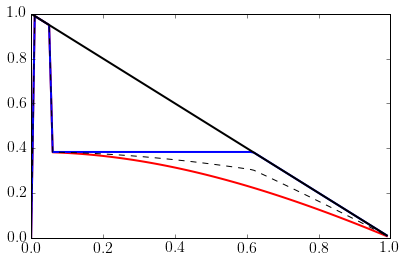

In [64]:
plt.plot(ys, ens1, c='r', lw=2)
plt.plot(ys, ens2, c='b', lw=2)
plt.plot(ys, (ens1 + ens2)/2, c='k', ls='--', lw=1)
plt.plot(ys, 1-ys, c='k', lw=2)
#plt.plot(ys, [gap(y, p.z) for y in ys], c='k', lw=2)

In [67]:
p = SimpleNamespace(tau=1.0, phi= np.pi / 2)
ys = np.linspace(0., 1, 100, endpoint=False)
energies = []
for y in ys:
    p.y = y
    sol = find_abs_energies(p)
    energies.append(sol)
    #gaps.append(compute_gap(p))
ens1, ens2 = np.asarray(zip(*energies))

No sign changes: 0
Discarding sign change detections: too close to each other.
No sign changes: 0
Discarding sign change detections: too close to each other.
No sign changes: 0


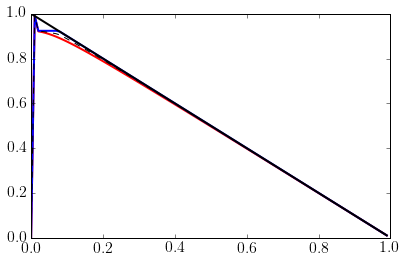

In [66]:
plt.plot(ys, ens1, c='r', lw=2)
plt.plot(ys, ens2, c='b', lw=2)
plt.plot(ys, (ens1 + ens2)/2, c='k', ls='--', lw=1)
plt.plot(ys, 1-ys, c='k', lw=2)
#plt.plot(ys, [gap(y, p.z) for y in ys], c='k', lw=2)

## Splitting of ABS

In [25]:
p = SimpleNamespace(tau=0.8, phi=np.pi)
ys = np.linspace(0., 1, 100, endpoint=False)
energies = []
for y in ys:
    p.y = y
    sol = find_abs_energies(p)
    energies.append(sol)
    #gaps.append(compute_gap(p))
ens1, ens2 = np.asarray(zip(*energies))

No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0


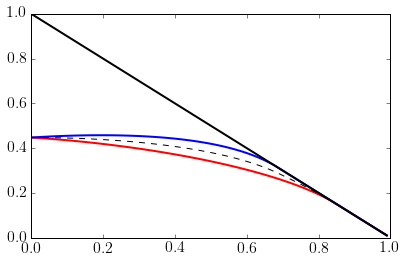

In [26]:
plt.plot(ys, ens1, c='r', lw=2)
plt.plot(ys, ens2, c='b', lw=2)
plt.plot(ys, (ens1 + ens2)/2, c='k', ls='--', lw=1)
plt.plot(ys, 1-ys, c='k', lw=2)
#plt.plot(ys, [gap(y, p.z) for y in ys], c='k', lw=2)

## Fit to experimental data

In [47]:
minima = [(0, 1.01809e-4),(50, 9.98742e-5),(75, 9.58812e-5),(100,9.2654e-5),
          (150,8.38036e-5),(200,7.27897e-5),(300,4.26e-5)]
Bs, Es = np.asarray(zip(*minima))
Es *= 1e6
Es /= GAP
popt, pcov = curve_fit(lambda x, gf: vfit_abs_pair_energy(x, gf, TAU, np.pi, GAP),
                       Bs[1:], Es[1:], p0=[3])
popt, pcov

No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0


(array([ 12.90689778]), array([[ 0.10728224]]))

In [48]:
p = SimpleNamespace(gfactor=popt[0], tau=TAU, phi=np.pi)
fields = np.linspace(0., 400, 100)
energies = []
gaps = []
for B in fields:
    p.y = 0.5 * p.gfactor * MU_B * B / GAP
    sol = find_abs_energies(p)
    energies.append(sol)
    gaps.append(1 - p.y)
ens1, ens2 = np.asarray(zip(*energies))

No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0


(0, 1)

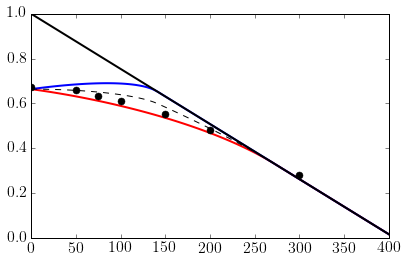

In [51]:
plt.plot(fields, ens1, c='r', lw=2)
plt.plot(fields, ens2, c='b', lw=2)
plt.plot(fields, (ens1 + ens2)/2, c='k', ls='--', lw=1)
plt.plot(fields, gaps, c='k', lw=2)
plt.plot(Bs, Es, 'o', c='k', markersize=7)
plt.ylim(0, 1)

## Fit to experimental data, including fit over transmission

In [52]:
minima = [(0, 1.01809e-4),(50, 9.98742e-5),(75, 9.58812e-5),(100,9.2654e-5),
          (150,8.38036e-5),(200,7.27897e-5),(300,4.26e-5)]
Bs, Es = np.asarray(zip(*minima))
Es *= 1e6
Es /= GAP
popt, pcov = curve_fit(lambda x, gf, tau: vfit_abs_pair_energy(x, gf, tau, np.pi, GAP),
                       Bs, Es, p0=[10, 0.6])
popt, pcov

No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0


(array([ 12.84540495,   0.57674583]), array([[ 0.08623754, -0.00059921],
        [-0.00059921,  0.00017253]]))

No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0


(0, 1)

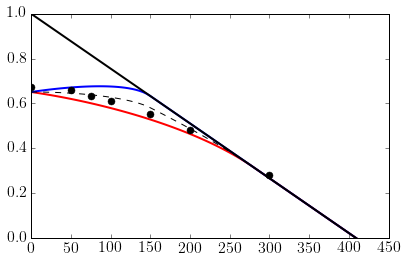

In [53]:
p = SimpleNamespace(gfactor=popt[0], tau=popt[1], phi=np.pi)
fields = np.linspace(0., 450, 100)
energies = []
gaps = []
for B in fields:
    p.y = 0.5 * p.gfactor * MU_B * B / GAP
    sol = find_abs_energies(p)
    energies.append(sol)
    gaps.append(1 - p.y)
ens1, ens2 = np.asarray(zip(*energies))
plt.plot(fields, ens1, c='r', lw=2)
plt.plot(fields, ens2, c='b', lw=2)
plt.plot(fields, (ens1 + ens2)/2, c='k', ls='--', lw=1)
plt.plot(fields, gaps, c='k', lw=2)
plt.plot(Bs, Es, 'o', c='k', markersize=7)
plt.ylim(0, 1)

## Fit to experimental data, including transmission, with a larger gap

In [61]:
HIGHER_GAP = 160
minima = [(0, 1.01809e-4),(50, 9.98742e-5),(75, 9.58812e-5),(100,9.2654e-5),
          (150,8.38036e-5),(200,7.27897e-5),(300,4.26e-5)]
Bs, Es = np.asarray(zip(*minima))
Es *= 1e6
Es /= HIGHER_GAP
popt, pcov = curve_fit(lambda x, gf, tau: vfit_abs_pair_energy(x, gf, tau, np.pi, HIGHER_GAP),
                       Bs, Es, p0=[10, 0.6])
popt, pcov

No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0


(array([ 13.79872228,   0.62407279]), array([[ 0.12435996, -0.000749  ],
        [-0.000749  ,  0.00016526]]))

No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0


(0, 1)

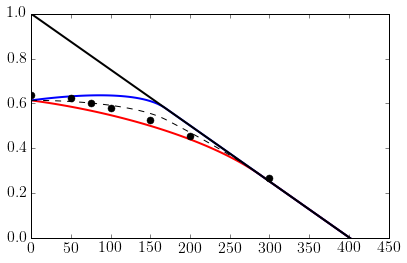

In [62]:
p = SimpleNamespace(gfactor=popt[0], tau=popt[1], phi=np.pi)
fields = np.linspace(0., 450, 100)
energies = []
gaps = []
for B in fields:
    p.y = 0.5 * p.gfactor * MU_B * B / HIGHER_GAP
    sol = find_abs_energies(p)
    energies.append(sol)
    gaps.append(1 - p.y)
ens1, ens2 = np.asarray(zip(*energies))
plt.plot(fields, ens1, c='r', lw=2)
plt.plot(fields, ens2, c='b', lw=2)
plt.plot(fields, (ens1 + ens2)/2, c='k', ls='--', lw=1)
plt.plot(fields, gaps, c='k', lw=2)
plt.plot(Bs, Es, 'o', c='k', markersize=7)
plt.ylim(0, 1)